# Processing Estimation Results

This section shows how to obtain and process estimation results.

In [1]:
# only necessary if you run this in a jupyter notebook
%matplotlib inline

import matplotlib.pyplot as plt
# import the base class:
from pydsge import * 
# import all the useful stuff from grgrlib:
from grgrlib import *

## Loading and printing stats

The meta data on estimation results is stored in the numpy-fileformat ``*.npz`` and is by default suffixed by the tag ``_meta``. An example is included with the package. Lets load it...

In [2]:
print(meta_data)
mod = DSGE.load(meta_data)

/home/gboehl/github/pydsge/pydsge/examples/dfi_doc0_meta.npz


Note that, again, `meta_data` is the path to the file.

As before, the `mod` object now collects all information and methods for the estimated model. That means you can do all the stuff that you could to before, like running `irfs` or the filter. It also stores some info on the estimation:

In [3]:
info = mod.info()

Title: dfi_doc0
Date: 2022-10-26 18:33:45.991271
Description: dfi, crisis sample
Parameters: 11
Chains: 40
Last 100 of 400 samples



The ``mod`` object provides access to the estimation stats:

In [4]:
summary = mod.mcmc_summary()

            distribution  pst_mean  sd/df   mean     sd   mode  hpd_5  hpd_95  \
theta               beta     0.500  0.100  0.816  0.028  0.826  0.763   0.857   
sigma             normal     1.500  0.375  2.359  0.294  2.294  1.904   2.816   
phi_pi            normal     1.500  0.250  2.168  0.169  2.100  1.945   2.468   
phi_y             normal     0.125  0.050  0.114  0.019  0.106  0.077   0.142   
rho_u               beta     0.500  0.200  0.956  0.009  0.962  0.941   0.967   
rho_r               beta     0.500  0.200  0.502  0.084  0.459  0.355   0.641   
rho_z               beta     0.500  0.200  0.996  0.003  0.997  0.993   1.000   
rho                 beta     0.750  0.100  0.825  0.026  0.817  0.787   0.869   
sig_u   inv_gamma_dynare     0.100  2.000  0.155  0.025  0.140  0.122   0.197   
sig_r   inv_gamma_dynare     0.100  2.000  0.099  0.012  0.107  0.078   0.115   
sig_z   inv_gamma_dynare     0.100  2.000  0.091  0.028  0.082  0.045   0.129   

        error  
theta   0.0

The ``summary`` is a `pandas.DataFrame` object, so you can do fancy things with it like ``summary.to_latex()``. Give it a try.

## Posterior sampling

One major interest is of course to be able to sample from the posterior. Get a sample of 100 draws:

In [5]:
pars = mod.get_par('posterior', nsamples=100, full=True)

Now, essentially everything is quite similar than before, when we sampled from the prior distribution. Let us run a batch of impulse response functions with these

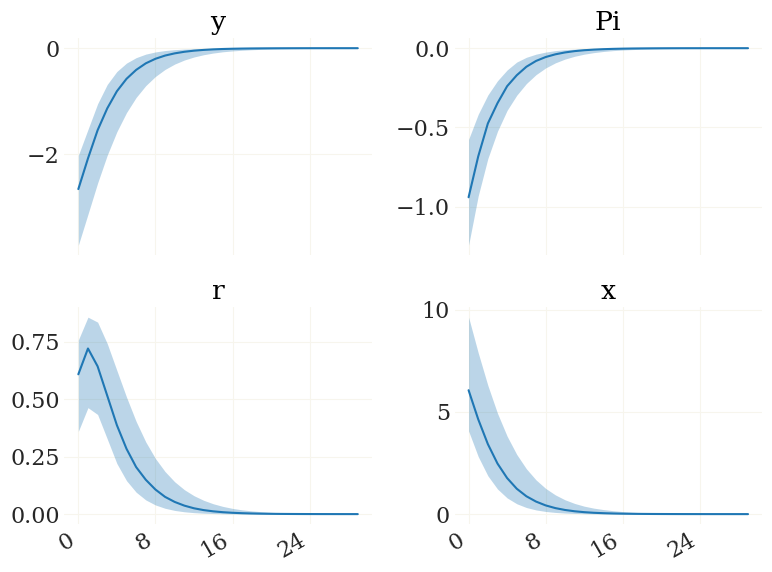

In [6]:
ir0 = mod.irfs(('e_r',1,0), pars)

# plot them:
v = ['y','Pi','r','x']
fig, ax, _ = pplot(ir0[0][...,mod.vix(v)], labels=v)

Note that you can also alter the parameters from the posterior. Lets assume you want to see what would happen if sigma is always one. Then you could create a parameter set like:

In [7]:
pars_sig1 = [mod.set_par('sigma',1,p) for p in pars]

This is in particular interesting if you e.g. want to study the effects of structural monetary policy. We can also extract the smoothened shocks to do some more interesting exercises. But before that, we have to load the filter used during the estimation:

In [8]:
# load filter:
mod.load_estim()
# extract shocks:
epsd = mod.extract(pars, nsamples=1, bound_sigma=4)

[estimation:]   Model operational. 12 states, 3 observables, 3 shocks, 81 data points.
Adding parameters to the prior distribution...
   - theta as beta (0.5, 0.1). Init @ 0.7813, with bounds (0.2, 0.95)
   - sigma as normal (1.5, 0.375). Init @ 1.2312, with bounds (0.25, 3)
   - phi_pi as normal (1.5, 0.25). Init @ 1.7985, with bounds (1.0, 3)
   - phi_y as normal (0.125, 0.05). Init @ 0.0893, with bounds (0.001, 0.5)
   - rho_u as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)
   - rho_r as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)
   - rho_z as beta (0.5, 0.2). Init @ 0.7, with bounds (0.01, 0.9999)
   - rho as beta (0.75, 0.1). Init @ 0.8, with bounds (0.5, 0.975)
   - sig_u as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.025, 5)
   - sig_r as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.01, 3)
   - sig_z as inv_gamma_dynare (0.1, 2). Init @ 0.5, with bounds (0.01, 3)
[estimation:]   11 priors detected. Adding parameters to the prior distrib

100%|██████████| 100/100 [00:24<00:00,  4.05 sample(s)/s]


``epsd`` is a dictionary containing the smoothed means, smoothened observables, the respective shocks and the parameters used for that, as explained in the previous section. Now that we have the shocks, we can again do a historical decomposition or run counterfactual experiments. The `bound_sigma` parameter adjusts the range in which the CMAES algoritm searches for a the set of shocks to fit the time series (in terms of shock standard deviations). A good model combined with a data set without strong irregularities (such as financial crises) should not need a high `bound_sigma`. The default value is to search within 4 shock standard deviations.